In [1]:
# pip install xgboost

In [2]:
# pip install catboost

In [3]:
# pip install imblearn

In [4]:
# pip install pyecharts

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import pyecharts as py
# from py import options as opts
# from py.charts import Sankey
import warnings

%matplotlib inline
%config InlineBackend.figure_format ="svg"
warnings.filterwarnings("ignore")

import sklearn
from sklearn import preprocessing #數據預處理
from sklearn.preprocessing import LabelEncoder #編碼轉換
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import StratifiedShuffleSplit #分層抽樣
from sklearn.model_selection import GridSearchCV #網路搜索
from sklearn.ensemble import RandomForestClassifier #隨機森林
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier #梯度提升
from sklearn.ensemble import  VotingClassifier #集成學習
from sklearn.svm import SVC,LinearSVC #支持向量機
from sklearn.linear_model import LogisticRegression #邏輯回歸
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #樸素貝葉斯
from sklearn.tree import DecisionTreeClassifier #決策樹分類器
from sklearn.decomposition import PCA #主成分分析法
from sklearn.cluster import KMeans#聚類算法
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import classification_report,precision_score,recall_score,f1_score
from sklearn.metrics import confusion_matrix#混淆矩陣
from sklearn.metrics import silhouette_score#輪廓係數
from sklearn.metrics import make_scorer #從性能指標或損失函數中創建一個記分標準
from sklearn.metrics import accuracy_score

from imblearn.over_sampling import SMOTE #隨機採樣處理不平衡數據問題 
from imblearn.under_sampling import RandomUnderSampler #隨機採樣處理數據不平衡問題

In [6]:
data = pd.read_csv("healthcare-dataset-stroke-data.csv")
data.head(2)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1


In [7]:
#查看數據整體情況
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [8]:
#刪除重複值
data = data.drop_duplicates()
data.shape

(5110, 12)

In [9]:
# 數據格式轉換
data["age"] = data["age"].astype(float).astype(int)#小數點型字符串先轉換為浮點型才能轉換為整數型，且轉換時向下取整
data["hypertension"] = data["hypertension"].astype(int)
data["heart_disease"] = data["heart_disease"].astype(int)
data["avg_glucose_level"] = data["avg_glucose_level"].astype(float)
data["bmi"] = data["bmi"].astype(float)
data["stroke"]= data["stroke"].astype(int)
# 查看轉換後的數據集情況
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   int32  
 3   hypertension       5110 non-null   int32  
 4   heart_disease      5110 non-null   int32  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int32  
dtypes: float64(2), int32(4), int64(1), object(5)
memory usage: 439.1+ KB


In [10]:
#查看數據描述統計
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.215264,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.633866,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.000000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [11]:
#查看數據集各列的唯一值數量
data.nunique()

id                   5110
gender                  3
age                    83
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
dtype: int64

In [12]:
# 定義函數查看每一列的唯一值
discrete_data = data[["gender","hypertension","heart_disease","ever_married","work_type","Residence_type","smoking_status","stroke"]]
def uni(columnlabel):
    print(columnlabel,"-----",discrete_data[columnlabel].unique())
# 查看每一列的唯一值
for i in range(0,len(discrete_data.columns)):
    uni(discrete_data.columns[i])

gender ----- ['Male' 'Female' 'Other']
hypertension ----- [0 1]
heart_disease ----- [1 0]
ever_married ----- ['Yes' 'No']
work_type ----- ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type ----- ['Urban' 'Rural']
smoking_status ----- ['formerly smoked' 'never smoked' 'smokes' 'Unknown']
stroke ----- [1 0]


In [13]:
#異常值處理
#查看性別異常值的數量
data.gender.value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [14]:
#刪除性別為其他的值
data = data.drop(data[data["gender"]=="Other"].index)
data.gender.value_counts()

Female    2994
Male      2115
Name: gender, dtype: int64

In [15]:
#查看吸煙狀態的人群數量
data.smoking_status.value_counts()


never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: smoking_status, dtype: int64

In [16]:
#將吸煙狀態的異常值替換為空值
data["smoking_status"].replace("Unknown",np.nan,inplace=True)
#用眾數填充缺失值
data["smoking_status"].fillna(data["smoking_status"].mode()[0],inplace=True)
data.smoking_status.value_counts()

never smoked       3436
formerly smoked     884
smokes              789
Name: smoking_status, dtype: int64

In [17]:
#填充缺失值
data["bmi"].fillna(data["bmi"].mean(),inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5109 non-null   int64  
 1   gender             5109 non-null   object 
 2   age                5109 non-null   int32  
 3   hypertension       5109 non-null   int32  
 4   heart_disease      5109 non-null   int32  
 5   ever_married       5109 non-null   object 
 6   work_type          5109 non-null   object 
 7   Residence_type     5109 non-null   object 
 8   avg_glucose_level  5109 non-null   float64
 9   bmi                5109 non-null   float64
 10  smoking_status     5109 non-null   object 
 11  stroke             5109 non-null   int32  
dtypes: float64(2), int32(4), int64(1), object(5)
memory usage: 439.1+ KB


In [18]:
def annot_plot(ax):
    ax.spines["top"].set_visible(False)#設置頂部邊框為空
    ax.spines["right"].set_visible(False) #設置右側邊框為空
    for p in ax.patches:
        ax.annotate(f"{p.get_height()*100/data.shape[0]:.2f}%",(p.get_x()+p.get_width()/2,p.get_height()),
                   ha="center",va="center",fontsize=11,color="black",rotation=0,xytext=(0,10),textcoords="offset points")

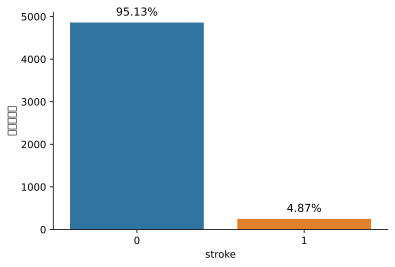

In [19]:
#數據集分佈情況
ax = sns.countplot("stroke",data=data)
plt.ylabel("中風發病率")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
for p in ax.patches:
    ax.annotate(f"{p.get_height()*100/data.shape[0]:.2f}%",(p.get_x()+p.get_width()/2,p.get_height()),
               ha="center",va="center",fontsize=11,color="black",rotation=0,xytext=(0,10),textcoords = "offset points")
plt.show()

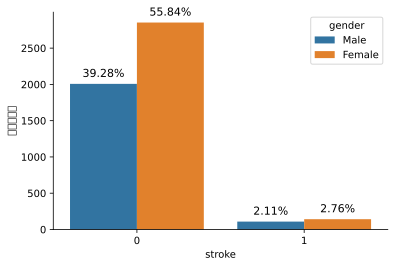

In [20]:
#性別與發病率的關係
ax = sns.countplot("stroke",hue="gender",data=data)
plt.ylabel("中風發病率")
annot_plot(ax)
plt.show()

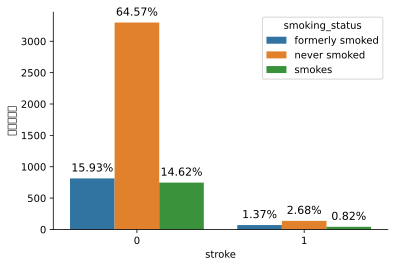

In [21]:
#吸煙狀態與中風發病率的關係
ax = sns.countplot("stroke",hue="smoking_status",data=data)
plt.ylabel("中風發病率")
annot_plot(ax)
plt.show()

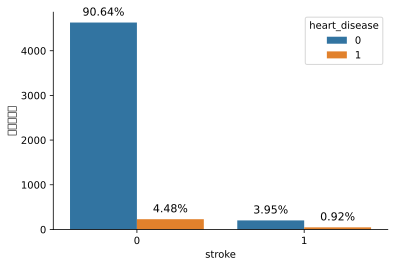

In [22]:
#中風與心髒病的關係
ax=sns.countplot("stroke",hue="heart_disease",data=data)
plt.ylabel("中風發病率")
annot_plot(ax)
plt.show()

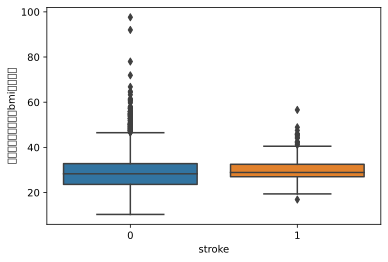

In [23]:
#bmi箱線圖
sns.boxplot(x="stroke",y="bmi",data=data)
plt.ylabel("中風與不中風人群的bmi分佈情況")
plt.show()

<AxesSubplot:ylabel='Density'>

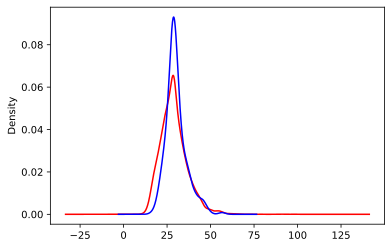

In [24]:
#bmi分佈密度圖
data["bmi"].plot.kde(color="red")
#患病用戶密度分佈
data.query("stroke==1")["bmi"].plot.kde(color="blue")

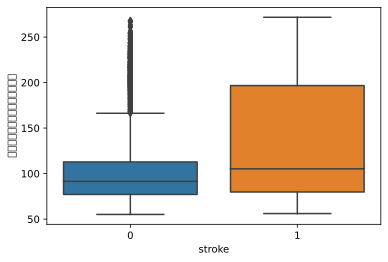

In [25]:
#血液中的葡萄糖水平的分佈
sns.boxplot(x="stroke",y="avg_glucose_level",data=data)
plt.ylabel("用戶人群的血液葡萄糖含量水平")
plt.show()


<AxesSubplot:ylabel='Density'>

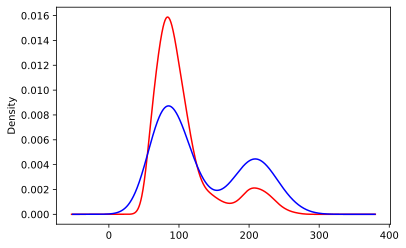

In [26]:
#avg_glucose_level分佈密度圖
data["avg_glucose_level"].plot.kde(color="red")
#患病用戶密度分佈
data.query("stroke==1")["avg_glucose_level"].plot.kde(color="blue")

In [27]:
#提取特徵
charges = data.drop(["id","stroke"],axis=1)
corrDf = charges.apply(lambda x:pd.factorize(x)[0])
corrDf.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,1,0,1,1,1,1,1
2,0,2,0,0,0,0,1,2,2,1
3,1,3,0,1,0,0,0,3,3,2
4,1,4,1,1,0,1,1,4,4,1


In [28]:
#構造相關性矩陣
corr=corrDf.corr()
corr

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
gender,1.000000,-0.008613,-0.021223,0.085685,-0.030171,-0.065848,-0.006105,0.007023,0.028407,0.021312
age,-0.008613,1.000000,-0.220881,0.203917,0.523630,0.234249,0.019538,0.072558,0.125254,0.091543
hypertension,-0.021223,-0.220881,1.000000,-0.108292,-0.164187,-0.075150,0.007980,-0.048336,-0.037028,-0.019315
heart_disease,0.085685,0.203917,-0.108292,1.000000,0.114601,0.058301,0.003045,0.054081,0.087604,0.016452
ever_married,-0.030171,0.523630,-0.164187,0.114601,1.000000,0.376238,0.005988,0.027844,0.113458,0.047306
work_type,-0.065848,0.234249,-0.075150,0.058301,0.376238,1.000000,-0.014426,0.028647,0.178520,-0.019389
Residence_type,-0.006105,0.019538,0.007980,0.003045,0.005988,-0.014426,1.000000,0.006394,-0.030769,-0.011823
avg_glucose_level,0.007023,0.072558,-0.048336,0.054081,0.027844,0.028647,0.006394,1.000000,0.112135,0.016570
bmi,0.028407,0.125254,-0.037028,0.087604,0.113458,0.178520,-0.030769,0.112135,1.000000,-0.011421
smoking_status,0.021312,0.091543,-0.019315,0.016452,0.047306,-0.019389,-0.011823,0.016570,-0.011421,1.000000


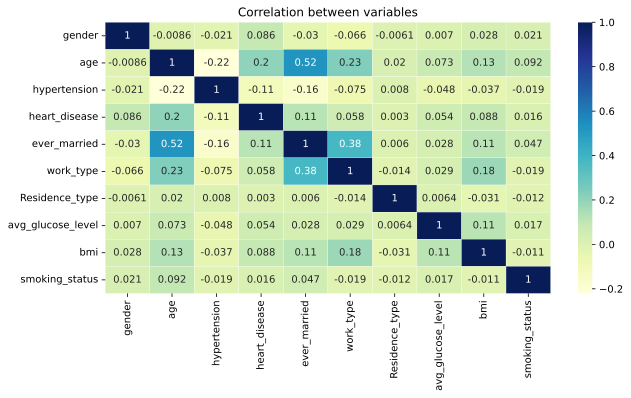

In [29]:
#繪製相關係數熱力地圖
plt.figure(figsize=(10,5),dpi=80)
ax = sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,
                linewidths=0.2,cmap="YlGnBu",annot=True)
plt.title("Correlation between variables")
plt.show()

In [30]:
#使用one_hot編碼查看數據之間的關係
one_hot_data = pd.get_dummies(data.iloc[:,1:])
one_hot_data.head(2)

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67,0,1,228.69,36.60000,1,0,1,0,1,0,0,1,0,0,0,1,1,0,0
1,61,0,0,202.21,28.89456,1,1,0,0,1,0,0,0,1,0,1,0,0,1,0


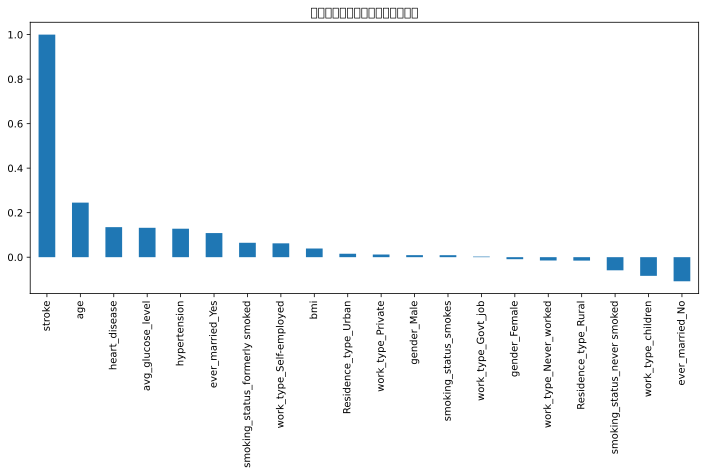

In [31]:
#用戶是否有中風與各變量之間的關係
plt.figure(figsize=(12,5))
one_hot_data.corr()["stroke"].sort_values(ascending=False).plot(kind="bar")
plt.title("用戶是否中風與各變量之間的關係")
plt.show()

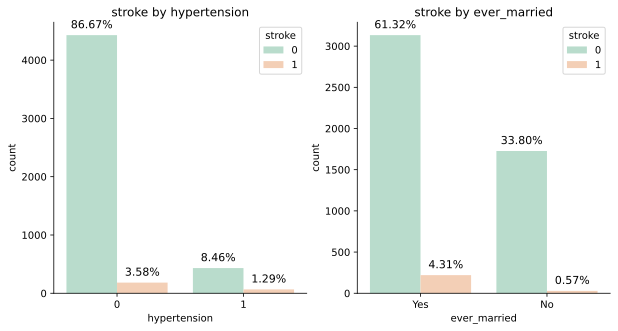

In [32]:
#中風與高血壓和婚姻狀態的關係
coveriables=["hypertension","ever_married"]
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
for i,item in enumerate(coveriables): #enumerate()函數用於將一個可遍歷的數據對象(如列表、元組或字符串)組合為一個索引序列，同時列出數據和數據下標，一般用在 for 循環當中。
    plt.subplot(1,2,(i+1))
    ax = sns.countplot(x=item,hue="stroke",data=data,palette="Pastel2")
    """countplot參數說明：Python數據可視化-seaborn庫之countplot - cymx66688 - 博客園"""
    plt.xlabel(str(item))
    plt.title("stroke by "+str(item))
    i=i+1
    annot_plot(ax)
plt.show()

In [33]:
#計算年齡分佈
age_data = data.pivot_table(index="age",columns="stroke",values="id",aggfunc="count")
age_data.head()

stroke,0,1
age,,
0,43.0,NaN
1,76.0,1.0
2,55.0,NaN
3,46.0,NaN
4,34.0,NaN


<AxesSubplot:xlabel='age'>

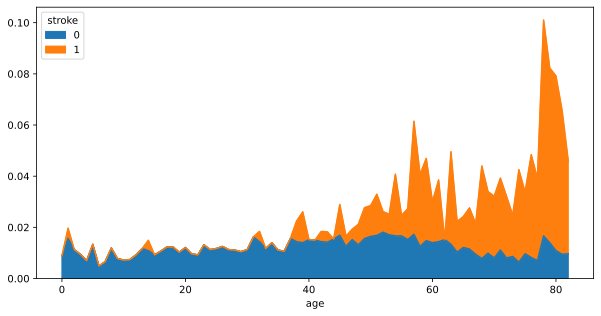

In [34]:
#求百分比繪圖,更能準確反應區別
age_data = age_data.apply(lambda x:x/x.sum())
#繪製堆積面積圖
age_data.plot.area(figsize=(10,5))

In [35]:
#選擇特徵值
data_comvar = data.drop(["id","gender","Residence_type","stroke"],axis=1)
data_comvar.head(2)

,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status
0,67,0,1,Yes,Private,228.69,36.60000,formerly smoked
1,61,0,0,Yes,Self-employed,202.21,28.89456,never smoked


In [36]:
#對連續變量進行標準化處理
scaler = StandardScaler(copy=False)
#fit_transform()先擬合數據，然後轉化數據將其變成標準形式
scaler.fit_transform(data_comvar[["age","avg_glucose_level","bmi"]])

array([[ 1.05075789e+00,  2.70644995e+00,  1.00103390e+00],
       [ 7.85653384e-01,  2.12165168e+00,  1.38462701e-15],
       [ 1.62515099e+00, -4.86741416e-03,  4.68392163e-01],
       ...,
       [-3.63132808e-01, -5.11265616e-01,  2.21558189e-01],
       [ 3.43812541e-01,  1.32837547e+00, -4.28004903e-01],
       [ 3.45239508e-02, -4.60692049e-01, -3.50057332e-01]])

In [37]:
#替換數據
data_comvar[["age","avg_glucose_level","bmi"]] = scaler.fit_transform(data_comvar[["age","avg_glucose_level","bmi"]])
data_comvar[["age","avg_glucose_level","bmi"]]

,age,avg_glucose_level,bmi
0,1.050758,2.706450,1.001034e+00
1,0.785653,2.121652,1.384627e-15
2,1.625151,-0.004867,4.683922e-01
3,0.255444,1.437473,7.152261e-01
4,1.580967,1.501297,-6.358651e-01
...,...,...,...
5105,1.625151,-0.494481,1.384627e-15
5106,1.669335,0.420922,1.442737e+00
5107,-0.363133,-0.511266,2.215582e-01
5108,0.343813,1.328375,-4.280049e-01


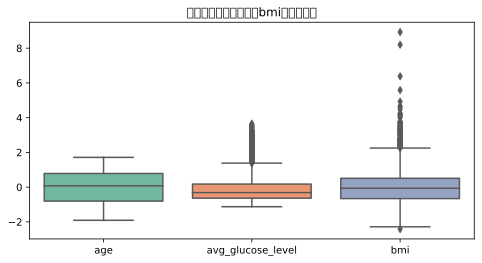

In [38]:
#使用箱線圖查看是否存在異常值
plt.figure(figsize=(8,4),dpi=80)
numbox=sns.boxplot(data=data_comvar[["age","avg_glucose_level","bmi"]],palette="Set2")
plt.title("年齡、平均血液水平和bmi分佈值情況")
plt.show()

In [39]:
#剔除異常值
"""定義函數：
允許函數輸入空值
data：表示dataFrame類型
n：表示被多少個特徵同時判定為異常點才輸出
features：表示檢測異常點的特徵
"""
def detect_outliers(data,n,features):
    outlier_indices=[]
    for col in features:
        #第一個四分位點
        #Q1 = data[col].describe()["25%"]
        Q1=np.percentile(data[col],25)
        #第三個四分位點
        #Q3 = data[col].describe()["75%"]
        Q3=np.percentile(data[col],75)
        IQR = Q3-Q1
        #極端上限和下限
        lower_limit = Q1-1.5*IQR
        upper_limit = Q3+1.5*IQR
        #查詢異常值的索引
        outlier_col = data[(data[col]<lower_limit)|(data[col]>upper_limit)].index
        #保存
        outlier_indices.extend(outlier_col)
    from collections import Counter
    outlier_indices = Counter(outlier_indices)
    #若被n特特徵同時判定為異常點才輸出
    more_outliers = list(k for k,v in outlier_indices.items() if v>=n)
    return more_outliers

In [40]:
#異常值的索引
outliers = detect_outliers(data_comvar,2,["avg_glucose_level","bmi"])
outliers

[21,
 66,
 113,
 254,
 258,
 417,
 466,
 544,
 595,
 1061,
 1257,
 1322,
 1529,
 1782,
 1898,
 2067,
 2081,
 2284,
 2290,
 2893,
 3060,
 3238,
 3243,
 3439,
 3594,
 3606,
 3688,
 3909,
 3931,
 3959,
 3980,
 4475,
 4636,
 4952]

In [41]:
#刪除特徵數據集異常值
data_comvar = data_comvar.drop(outliers,axis=0).reset_index(drop=True)
data_comvar.head(2)

,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status
0,1.050758,0,1,Yes,Private,2.706450,1.001034e+00,formerly smoked
1,0.785653,0,0,Yes,Self-employed,2.121652,1.384627e-15,never smoked


In [42]:
#刪除原數據集異常值
data = data.drop(outliers,axis=0).reset_index(drop=True)
data.head(2)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67,0,1,Yes,Private,Urban,228.69,36.60000,formerly smoked,1
1,51676,Female,61,0,0,Yes,Self-employed,Rural,202.21,28.89456,never smoked,1


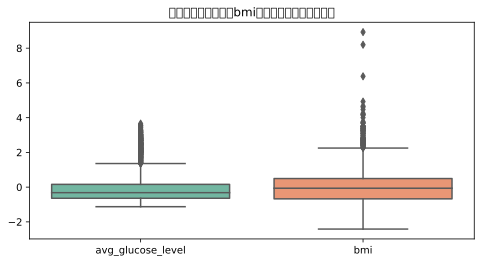

In [43]:
#檢查異常值是否清理完成
plt.figure(figsize=(8,4),dpi=80)
numbox = sns.boxplot(data = data_comvar[["avg_glucose_level","bmi"]],palette="Set2")
plt.title("檢查血液血糖水平和bmi異常值清理後的分佈情況")
plt.show()

In [44]:
#查看對像類型字段裡面存在的值
def uni(columnlabel):
    print(columnlabel,"-----",data_comvar[columnlabel].unique())
data_comvar_object = data_comvar.select_dtypes(["object"])
for i in range(0,len(data_comvar_object.columns)):
    uni(data_comvar_object.columns[i])

ever_married ----- ['Yes' 'No']
work_type ----- ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
smoking_status ----- ['formerly smoked' 'never smoked' 'smokes']


In [45]:
#使用scikit_learn標籤編碼，將分類數據轉換為整數編碼
def labelencode(columnlabel):
    data_comvar[columnlabel] = LabelEncoder().fit_transform(data_comvar[columnlabel])
#進行標籤編碼：
for i in range(0,len(data_comvar_object.columns)):
    labelencode(data_comvar_object.columns[i])
#展示
for i in range(0,len(data_comvar_object.columns)):
    uni(data_comvar_object.columns[i])

ever_married ----- [1 0]
work_type ----- [2 3 0 4 1]
smoking_status ----- [0 1 2]


In [46]:
#查看特徵處理完畢的數據集情況
data_comvar.head()

,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status
0,1.050758,0,1,1,2,2.706450,1.001034e+00,0
1,0.785653,0,0,1,3,2.121652,1.384627e-15,1
2,1.625151,0,1,1,2,-0.004867,4.683922e-01,1
3,0.255444,0,0,1,2,1.437473,7.152261e-01,2
4,1.580967,1,0,1,3,1.501297,-6.358651e-01,1


In [47]:
#****************************************


In [48]:
# 1、建立訓練和測試數據集
"""拆分數據集時，由於我們的數據集是不平衡的，所以最好使用分層交叉驗證來確保訓練集和測試集都包含每個類樣本的保留人數。
交叉驗證函數StratifiedShuffleSplit，分層抽樣功能保每個標籤對應的樣本的比例，是從樣本數據中隨機按比例選擇訓練數據和測試數據
參數n_splite是將訓練數據分成train/test對的組數，可根據需要進行設置，默認為10
參數test_size和train_size是用來設置train/test對中train和test所佔的比例
參數random_state 控制是將樣本隨機打亂
"""
X=data_comvar
y=data["stroke"].values

spl = StratifiedShuffleSplit(n_splits=5,test_size=0.2,random_state=0)
print(spl)
print("訓練數據集和測試數據集被分成的組數：",spl.get_n_splits(X,y))

StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.2,
            train_size=None)
训练数据集和测试数据集被分成的组数： 5


In [49]:
#目標y值
data["stroke"].values

array([1, 1, 1, ..., 0, 0, 0])

In [50]:
#查看訓練數據集和測試數據集
for train_index,test_index in spl.split(X,y):
    print("train:",train_index,"test:",test_index)
    X_train,X_test=X.iloc[train_index],X.iloc[test_index]
    y_train,y_test = y[train_index],y[test_index]

train: [2705  713 3277 ... 4587   79 1495] test: [2213 3355  329 ... 2835 2677 1630]
train: [2271 1665 3058 ... 3176 2138  319] test: [ 544  224  803 ... 2264 3489 2993]
train: [4265 3338 3295 ...  678 3542  360] test: [4373 1685 3030 ...  647 2049 3052]
train: [2288 2823 4743 ... 2009 3646  332] test: [2475 4178 2550 ... 4992 2600 4692]
train: [4469 2633  317 ... 1166 3851  421] test: [ 227  268 3339 ...  936 1067 2170]


In [51]:
#輸出數據集大小
print("原始數據集特徵：",X.shape,
     "訓練數據集特徵：",X_train.shape,
     "測試數據集特徵：",X_test.shape)
print("原始數據集標籤：",y.shape,
     "訓練數據集標籤：",y_train.shape,
     "測試數據集標籤：",y_test.shape)

原始数据集特征： (5075, 8) 训练数据集特征： (4060, 8) 测试数据集特征： (1015, 8)
原始数据集标签： (5075,) 训练数据集标签： (4060,) 测试数据集标签： (1015,)


In [52]:
#採用SMOTE處理數據不平衡問題
smo = SMOTE(random_state=42)
x_smo,y_smo = smo.fit_resample(X_train,y_train)
print(x_smo.shape,y_smo.shape)

(7726, 8) (7726,)


In [53]:
#2、選擇機器學習算法
"""使用分類算法，這裡選擇十種分類算法"""
Classifiers=[
    ["Random Forest",RandomForestClassifier()],
    ["Support Vector Machine",SVC()],
    ["LogisticRegression",LogisticRegression()],
    ["KNN",KNeighborsClassifier()],
    ["Naive Bayes",GaussianNB()],
    ["Decision Tree",DecisionTreeClassifier()],
    ["AdaBoostClassifier",AdaBoostClassifier()],
    ["GradientBoostingClassifier",GradientBoostingClassifier()],
    ["XGB",XGBClassifier()],
    ["CatBoost",CatBoostClassifier()]
]

In [57]:
from sklearn.metrics import roc_auc_score
#3、訓練模型
Classify_result=[]
names=[]
prediction=[]
for name,classifier in Classifiers:
    classifier = classifier
    #訓練模型
    classifier.fit(x_smo,y_smo)
    #目標预测值
    y_pred = classifier.predict(X_test)
    #召回率
    recall = recall_score(y_test,y_pred)
    #準確率
    precision = precision_score(y_test,y_pred)
    #f1综合得分
    f1 = f1_score(y_test,y_pred)
    #準確度
    accuracy=accuracy_score(y_test,y_pred)
    #
    ROC_score=roc_auc_score(y_test,y_pred)
    #評估結果合併
    class_eva = pd.DataFrame([recall,precision,f1,accuracy,ROC_score])
    Classify_result.append(class_eva)
    #模型名稱
    name=pd.Series(name)
    names.append(name)
    #預測結果
    y_pred = pd.Series(y_pred)
    prediction.append(y_pred)

Learning rate set to 0.024666
0:	learn: 0.6765564	total: 145ms	remaining: 2m 25s
1:	learn: 0.6606394	total: 148ms	remaining: 1m 13s
2:	learn: 0.6490228	total: 151ms	remaining: 50.3s
3:	learn: 0.6375143	total: 154ms	remaining: 38.3s
4:	learn: 0.6245425	total: 157ms	remaining: 31.2s
5:	learn: 0.6139287	total: 159ms	remaining: 26.4s
6:	learn: 0.6022069	total: 162ms	remaining: 23s
7:	learn: 0.5937093	total: 165ms	remaining: 20.4s
8:	learn: 0.5847784	total: 168ms	remaining: 18.5s
9:	learn: 0.5762713	total: 170ms	remaining: 16.9s
10:	learn: 0.5705930	total: 172ms	remaining: 15.5s
11:	learn: 0.5621437	total: 176ms	remaining: 14.5s
12:	learn: 0.5561051	total: 179ms	remaining: 13.6s
13:	learn: 0.5492434	total: 182ms	remaining: 12.8s
14:	learn: 0.5438527	total: 185ms	remaining: 12.2s
15:	learn: 0.5373029	total: 189ms	remaining: 11.6s
16:	learn: 0.5293732	total: 192ms	remaining: 11.1s
17:	learn: 0.5237594	total: 195ms	remaining: 10.7s
18:	learn: 0.5194366	total: 198ms	remaining: 10.2s
19:	learn: 

In [58]:
#4、評估模型
"""recall召回率：原本為對的當中，預測為對的比例（值越大越好，1為理想狀態）
precision精確率：預測為對的當中，原本為對的比例（值越大越好，1為理想狀態）
F1-Score F1分數：指標綜合了Precision和recall的產出結果
F1-Score取值範圍0-1，1代表模型輸出的結果最好，0代表模型輸出結果最差
"""
names = pd.DataFrame(names)
names = names[0].tolist()
#將各個結果合併在一起
result = pd.concat(Classify_result,axis=1)
result.columns = names
result.index=["recall","precision","F1_score","accuracy_score","ROC_score"]
result

,Random Forest,Support Vector Machine,LogisticRegression,KNN,Naive Bayes,Decision Tree,AdaBoostClassifier,GradientBoostingClassifier,XGB,CatBoost
recall,0.367347,0.775510,0.755102,0.591837,0.836735,0.387755,0.693878,0.714286,0.102041,0.224490
precision,0.137405,0.118012,0.118211,0.121849,0.114846,0.118750,0.114094,0.139442,0.108696,0.129412
F1_score,0.200000,0.204852,0.204420,0.202091,0.201970,0.181818,0.195965,0.233333,0.105263,0.164179
accuracy_score,0.858128,0.709360,0.716256,0.774384,0.680788,0.831527,0.725123,0.773399,0.916256,0.889655
ROC_score,0.625185,0.740757,0.734694,0.687740,0.754806,0.620896,0.710293,0.745342,0.529799,0.573943


In [59]:
#預測數據集特徵
pred_X = data_comvar.tail(100)
#提取id
pred_id = data["id"].tail(100)

#使用樸素貝葉斯方法，預測用戶中風情況
model = GradientBoostingClassifier()
model.fit(X_train,y_train)
pred_y = model.predict(pred_X)

#預測結果
predDf = pd.DataFrame({"id":pred_id,"stroke":pred_y})
predDf

,id,stroke
4975,58635,0
4976,844,0
4977,14688,0
4978,23026,0
4979,30463,0
...,...,...
5070,18234,0
5071,44873,0
5072,19723,0
5073,37544,0


In [ ]:
#define metrics
y_pred_proba = lr.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC for Logistic Regression')
plt.show()

In [ ]:
#圖表大小
figure, axes = plt.subplots(nrows=n_rows, ncols=n_cols,figsize=(30, 100))
figure.suptitle('\n\nCategorical Features\nVS\nTarget Variable', fontsize=100) 
    #繪製熱力圖
    sns.heatmap(pd.crosstab(data[column],data['Chronic Kidney Disease']),
                ax=axes[i,j],
                cmap=sns.cubehelix_palette(start=2.8, rot=.1),
                square='True',
                cbar=False,
                annot=True,
                annot_kws={'fontsize':90},
                fmt='d')
        
plt.show()